# Импорт библиотек

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt 
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Импорт данных

In [2]:
etalons = gpd.read_file('../forests-wgs84/wgs84-etalons.shp').to_crs('EPSG:4326').dropna()
boundary = gpd.read_file('../forests-wgs84/wgs84-forestry-bounds.shp').to_crs('EPSG:4326')
clearcuts = gpd.read_file('../forests-wgs84/wgs84-etalons-clearcuts.shp').to_crs('EPSG:4326')

# 1. Анализ и визуализация данных. Определение породного состава леса

Для каждой породы дерева (а также для позиции 000000) выведем его распространение в границах заданного участка.

In [3]:
etalons['area'] = etalons.geometry.to_crs('EPSG:3857').area
woods_percentage = (etalons.groupby(['Mr1'])['area'].sum() / etalons['area'].sum() * 100)\
                            .sort_values(ascending=False).round(2)\
                            .apply(lambda x: f'{x}%').reset_index().rename(columns={'Mr1': 'Сокращение', 'area': '% распространения'})

wood_fool = {'С': 'Сосна обыкновенная', 'Б': 'Берёза повислая', '000000': 'Не покрытые древесно-кустарниковой растительностью',
                                   'ОС': 'Осина', 'Е': 'Ель европейская', 'Л': 'Лиственница сибирская'}

woods_percentage['Расшифровка'] = woods_percentage['Сокращение'].apply(lambda x: wood_fool[x])
etalons['Расшифровка'] = etalons['Mr1'].apply(lambda x: wood_fool[x])

woods_percentage[['Сокращение', 'Расшифровка', '% распространения']]

,Сокращение,Расшифровка,% распространения
0,С,Сосна обыкновенная,56.66%
1,Б,Берёза повислая,30.19%
2,000000,Не покрытые древесно-кустарниковой растительно...,11.82%
3,ОС,Осина,0.75%
4,Е,Ель европейская,0.44%
5,Л,Лиственница сибирская,0.14%


Визуализируем результат (только для пород деревьев) в виде карт. 

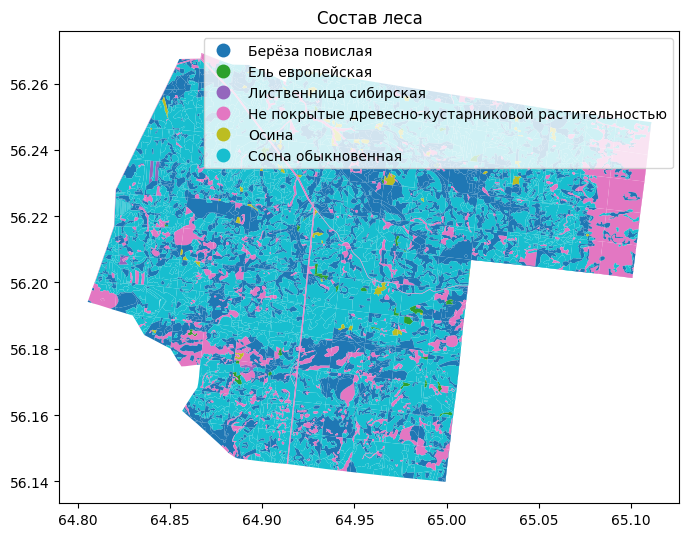

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
etalons.plot(column='Расшифровка', legend=True, ax=ax)
ax.set_title('Состав леса');

Рассчитаем площадь породного состава леса (по каждой породе).

In [5]:
etalons['area'] = etalons.geometry.to_crs('EPSG:3857').area
woods_area = (etalons.groupby(['Mr1'])['area'].sum())\
                            .sort_values(ascending=False).round(2)\
                            .apply(lambda x: f'{x}').reset_index().rename(columns={'Mr1': 'Сокращение', 'area': 'Площадь леса'})

woods_area['Расшифровка'] = woods_area['Сокращение'].apply(lambda x: wood_fool[x])

woods_area[['Сокращение', 'Расшифровка', 'Площадь леса']]

,Сокращение,Расшифровка,Площадь леса
0,С,Сосна обыкновенная,313200969.51
1,Б,Берёза повислая,166890031.51
2,000000,Не покрытые древесно-кустарниковой растительно...,65319483.4
3,ОС,Осина,4149159.44
4,Е,Ель европейская,2456901.13
5,Л,Лиственница сибирская,793596.62


Для каждого ареала рассчитаем: средний возраст леса, средний запас древесины,
распределение (в %) зон – хвойные, лиственные, зоны без леса. 

In [6]:
# Средний возраст леса,
# Средний возраст леса для каждого ареала можно рассчитать как средневзвешенное значение возрастов древесных пород
# с учётом их доли в запасе древесины
etalons['avg_age'] = \
((etalons['Amz1'] * etalons['Kf1'] + etalons['Amz2'] * etalons['Kf2'] + \
 etalons['Amz3'] * etalons['Kf3'] + etalons['Amz4'] * etalons['Kf4'] + \
 etalons['Amz5'] * etalons['Kf5']) / (etalons['Kf1'] + etalons['Kf2'] + etalons['Kf3'] + etalons['Kf4'] + etalons['Kf5'])).fillna(0)

# Средний запас древесины
# Средний запас древесины для каждого ареала можно рассчитать как сумму запасов древесины по всем древесным породам

etalons['avg_tur1h'] = etalons['Tur1h1'] + etalons['Tur1h2'] + etalons['Tur1h3'] + etalons['Tur1h4'] + etalons['Tur1h5'] 

# Распределение (в %) зон – хвойные, лиственные, зоны без леса.
etalons['avg_leaves'] = 0 
etalons['avg_conifer'] = 0 
etalons['avg_without_trees'] = 0

def get_precentage_zone(row):
    total_kf = sum([row.loc[f'Kf{level}'] for level in range(1, 6)])
    
    conifer = 0
    leaves = 0
    without_trees = 0
    
    for level in range(1, 6):
        
        # хвойные
        if row.loc[f'Mr{level}'] in (['Е', 'С', 'Л']):
            conifer += row.loc[f'Kf{level}'] 
    
        # лиственные
        if row.loc[f'Mr{level}'] in (['Б', 'ОС']):
            leaves += row.loc[f'Kf{level}'] 
    
        # зоны без леса
        if row.loc[f'Mr{level}'] == 000000:
            without_trees += row.loc[f'Kf{level}']

    if total_kf:
        avg_conifer = round(conifer / total_kf * 100, 2)
        avg_leaves = round(leaves / total_kf * 100, 2)
        avg_without_trees = round(without_trees / total_kf * 100, 2)
        
        return pd.Series(((avg_conifer), (avg_leaves), (avg_without_trees)))

    return pd.Series(((0.0), (0.0), (100.0)))


etalons[['avg_conifer', 'avg_leaves', 'avg_without_trees']] = etalons.apply(get_precentage_zone, axis=1)

etalons.head()

,Kv,Sknr,Kf1,Mr1,Amz1,H1,D1,Skal1,Tur1h1,Kf2,...,Skal5,Tur1h5,geometry,area,Расшифровка,avg_age,avg_tur1h,avg_leaves,avg_conifer,avg_without_trees
0,1,3,0,000000,0,0.0,0,0.0,0,0,...,0.0,0,"POLYGON ((64.85809 56.26744, 64.85822 56.26739...",15098.595977,Не покрытые древесно-кустарниковой растительно...,0.0,0,0.0,0.0,100.0
1,1,4,8,Б,65,23.0,26,0.6,170,2,...,0.0,0,"POLYGON ((64.85459 56.26687, 64.85505 56.26742...",87624.024694,Берёза повислая,52.0,170,80.0,20.0,0.0
2,1,5,0,000000,0,0.0,0,0.0,0,0,...,0.0,0,"POLYGON ((64.86062 56.26735, 64.86188 56.26745...",6493.891059,Не покрытые древесно-кустарниковой растительно...,0.0,0,0.0,0.0,100.0
3,1,6,8,С,85,27.0,36,0.7,360,2,...,0.0,0,"POLYGON ((64.86372 56.26719, 64.86444 56.26729...",89617.431197,Сосна обыкновенная,68.0,360,20.0,80.0,0.0
4,1,7,0,000000,0,0.0,0,0.0,0,0,...,0.0,0,"POLYGON ((64.86595 56.26734, 64.86599 56.26665...",10545.511191,Не покрытые древесно-кустарниковой растительно...,0.0,0,0.0,0.0,100.0


Выделим ТОР-10 участков, с наибольшим запасом леса, выведем координаты этих
участков

In [7]:
etalons.sort_values(by='avg_tur1h', ascending=False).head(10)[['geometry', 'avg_tur1h']]

,geometry,avg_tur1h
800,"POLYGON ((65.00317 56.23952, 65.00477 56.23953...",490
4040,"POLYGON ((64.9693 56.1655, 64.97062 56.16547, ...",480
984,"POLYGON ((64.88297 56.24217, 64.88292 56.24226...",470
753,"POLYGON ((65.00356 56.24553, 65.00363 56.24627...",470
3146,"POLYGON ((64.92933 56.2015, 64.92985 56.20147,...",470
268,"POLYGON ((64.99319 56.24927, 64.9933 56.25025,...",470
2827,"POLYGON ((64.94318 56.20236, 64.9433 56.20221,...",470
3156,"POLYGON ((64.92357 56.19511, 64.92392 56.19513...",470
453,"POLYGON ((64.85927 56.25213, 64.85958 56.25244...",470
461,"POLYGON ((64.84979 56.24879, 64.85063 56.24832...",470


Визуализируем эти участки – выделим их границы на карте, закрасим цветом.

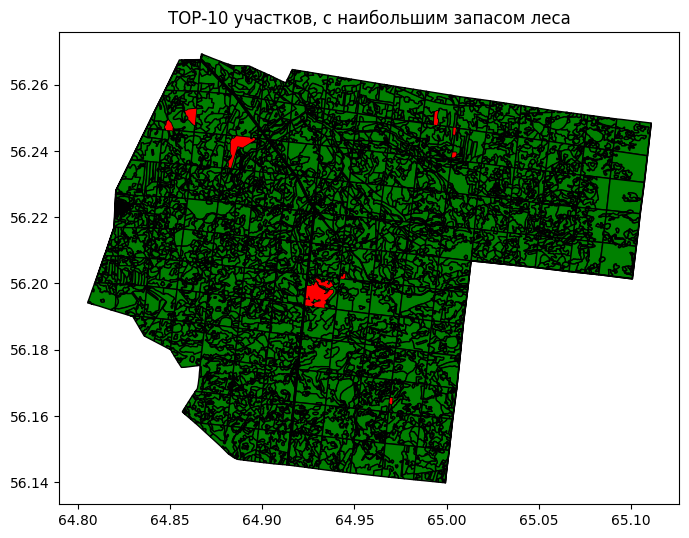

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
etalons.plot(color='green', edgecolor='black', ax=ax)
etalons.sort_values(by='avg_tur1h', ascending=False).head(10)[['geometry', 'avg_tur1h']].plot(color='red', ax=ax)
ax.set_title('ТОР-10 участков, с наибольшим запасом леса');

# 2. Определение ареалов с зонами вырубки леса

Определим ареалы с зонами проведения рубок леса за промежуток времени с 2021 по
2024 годы, оценим их площадь

In [9]:
clearcuts['area'] = clearcuts.geometry.to_crs('EPSG:3857').area
clearcuts[['код', 'area']].head()

,код,area
0,43100020101080201,120870.338841
1,43100020101090101,111708.557365
2,43100020101180201,43585.989201
3,43100020101180301,104109.356509
4,43100020101240101,302268.157744


Определите зоны с наибольшей площадью вырубки, отобразите границы этих зон на карте

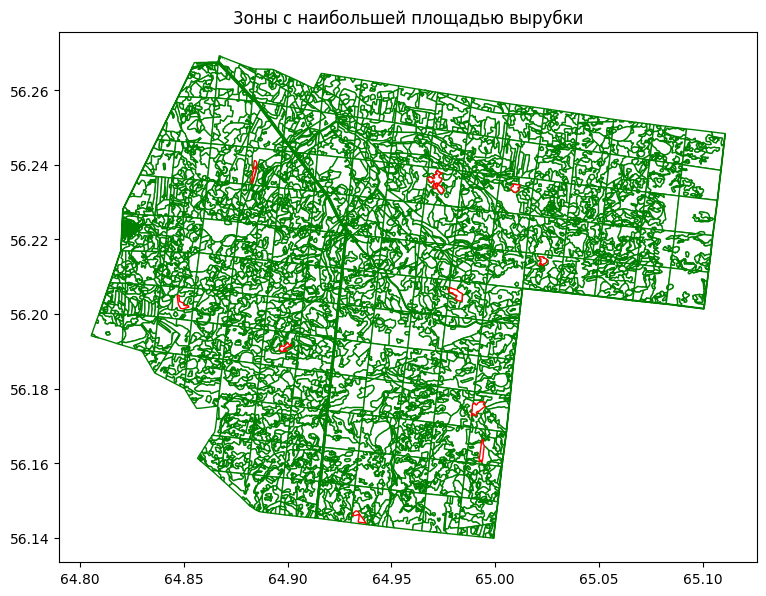

In [10]:
fig, ax = plt.subplots(figsize=(9, 9))
etalons.plot(color='white', edgecolor='green', ax=ax)
# Первые 10 зон
clearcuts.sort_values(by='area', ascending=False).head(10).plot(edgecolor='red', color='white', ax=ax)
ax.set_title('3оны с наибольшей площадью вырубки');


# 3. Сегментация изображений - кластеризации ареалов леса по типам, возрасту, запасам древесины

### Предобработка данных

Для методов кластеризации преобразуем категориальные признаки и отмасштабируем данные, заполним пропуски.

In [16]:
X = etalons.drop(['geometry', 'Расшифровка'], axis=1)

cat_columns = ['Mr1', 'Mr2', 'Mr3', 'Mr4', 'Mr5']
num_columns = [col for col in X.columns if col not in cat_columns]

cat_pipeline = Pipeline([
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('encoder', OneHotEncoder()),
])

num_pipeline = Pipeline([
     ('imputer', SimpleImputer(strategy='median')),
])

transformer = ColumnTransformer([
    ('cat_pipeline', cat_pipeline, cat_columns),
    ('num_pipeline', num_pipeline, num_columns),
])

preprocessor = Pipeline([
     ('transformer', transformer),
     ('scaler', StandardScaler())
])

X = pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out())
X.columns = [x.split('__')[1] for x in X.columns]
X = X[['area', 'avg_age', 'avg_tur1h', 'avg_leaves', 'avg_conifer', 'avg_without_trees']]
X.head()

In [21]:
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

## Выбор алгоритма кластеризации<br>
1. <b>KMeans</b> 
2. <b>MiniBatchKMeans</b> 
3. <b>Birch</b> 

<br> Обоснуем выбор алгоритма исходя из метрик:
1. <b>Индекс Калинского-Харабаша</b> - критерий коэффициента дисперсии, где более высокий показатель индекса Калински-Харабаского относится к модели с более четко определенными кластерами.
2. <b>Индекс Дэвиса-Булдина</b> - более низкий индекс Дэвиса-Булдина относится к модели с лучшим разделением между кластерами.
Этот индекс означает среднее “сходство” между кластерами, где сходство - это мера, сравнивающая расстояние между кластерами с размером самих кластеров.
3. <b>Коэффициент силуэта</b> - более высокий балл коэффициента силуэта относится к модели с более четко определенными кластерами. Коэффициент силуэта определяется для каждого образца и состоит из двух баллов:
    - Среднее расстояние между образцом и всеми другими точками того же класса.
    - Среднее расстояние между образцом и всеми остальными точками в следующем ближайшем кластере.



## KMeans

In [33]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans_labels = kmeans.predict(X)

### Визуализация

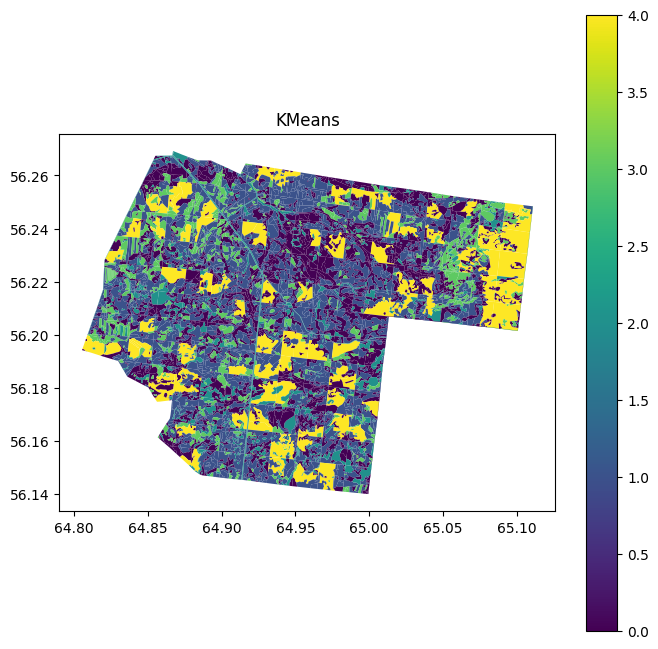

In [34]:
fig, ax = plt.subplots(figsize=(8,8))
etalons.plot(column=kmeans_labels, ax=ax, legend=True)

ax.set_title('KMeans');

### Оценка качества работы

In [35]:
# Индекс Калинского-Харабаша
print(f'Индекс Калинского-Харабаша для данного алгоритма: {calinski_harabasz_score(X, kmeans_labels):.2f}')

# Индекс Дэвиса-Булдина
print(f'Индекс Дэвиса-Булдина для данного алгоритма: {davies_bouldin_score(X, kmeans_labels):.2f}')

# Коэффициент силуэта
print(f'Коэффициент силуэта для данного алгоритма: {silhouette_score(X, kmeans_labels):.2f}')

Индекс Калинского-Харабаша для данного алгоритма: 4202.88
Индекс Дэвиса-Булдина для данного алгоритма: 0.82
Коэффициент силуэта для данного алгоритма: 0.49


## MiniBatchKMeans

In [36]:
MBkmeans = MiniBatchKMeans(n_clusters=5)
MBkmeans.fit(X)
MBkmeans_labels = MBkmeans.predict(X)

### Визуализация

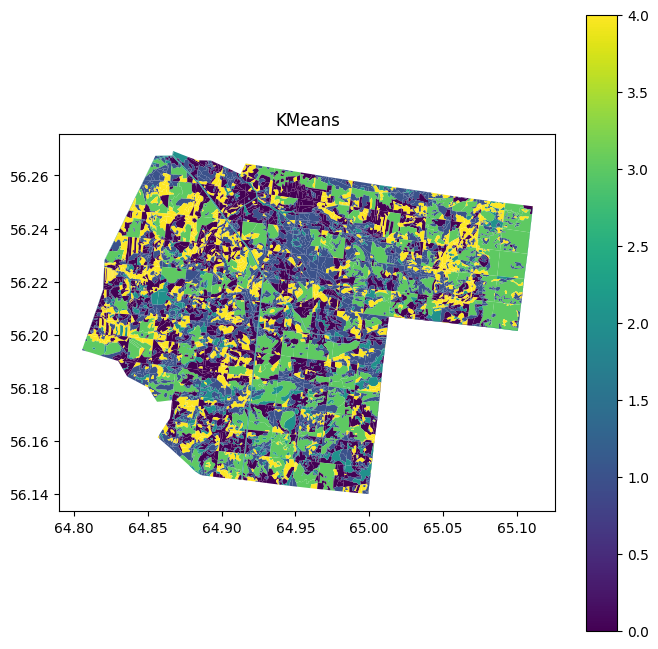

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
etalons.plot(column=MBkmeans_labels, ax=ax, legend=True)

ax.set_title('KMeans');

### Оценка качества работы

In [38]:
# Индекс Калинского-Харабаша
print(f'Индекс Калинского-Харабаша для данного алгоритма: {calinski_harabasz_score(X, MBkmeans_labels):.2f}')

# Индекс Дэвиса-Булдина
print(f'Индекс Дэвиса-Булдина для данного алгоритма: {davies_bouldin_score(X, MBkmeans_labels):.2f}')

# Коэффициент силуэта
print(f'Коэффициент силуэта для данного алгоритма: {silhouette_score(X, MBkmeans_labels):.2f}')

Индекс Калинского-Харабаша для данного алгоритма: 4070.26
Индекс Дэвиса-Булдина для данного алгоритма: 0.89
Коэффициент силуэта для данного алгоритма: 0.47


## Birch

In [39]:
birch = Birch(n_clusters=5)
birch.fit(X)
birch_labels = birch.predict(X)

### Визуализация

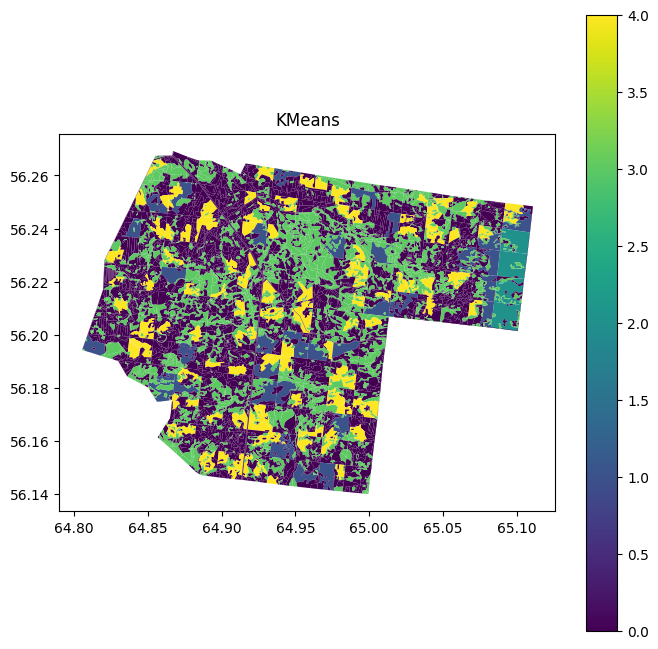

In [40]:
fig, ax = plt.subplots(figsize=(8,8))
etalons.plot(column=birch_labels, ax=ax, legend=True)

ax.set_title('KMeans');

### Оценка качества работы

In [41]:
# Индекс Калинского-Харабаша
print(f'Индекс Калинского-Харабаша для данного алгоритма: {calinski_harabasz_score(X, birch_labels):.2f}')

# Индекс Дэвиса-Булдина
print(f'Индекс Дэвиса-Булдина для данного алгоритма: {davies_bouldin_score(X, birch_labels):.2f}')

# Коэффициент силуэта
print(f'Коэффициент силуэта для данного алгоритма: {silhouette_score(X, birch_labels):.2f}')

Индекс Калинского-Харабаша для данного алгоритма: 678.11
Индекс Дэвиса-Булдина для данного алгоритма: 0.99
Коэффициент силуэта для данного алгоритма: 0.29


## Вывод

Визуально все методы хорошо кластеризовали данные. Лучший алгоритм кластеризации по 2 метрикам из 3 стал <b>Birch</b>.

Добавим номер кластера как дополнительный атрибут в исходный массив атрибутов для каждого ареала леса

In [42]:
etalons['cluster'] = birch_labels

etalons.reset_index().to_csv('../etalons_with_cluster.csv', index=False)

In [44]:
joblib.dump(birch, 'clustering.pkl')

['clustering.pkl']

### Описание кластеров

1. Самое большое количество лиственных деревьев
2. Самая большая площадь и запас древесины
3. Средний лес с равным количеством хвойных и лиственных дереьев
4. Самый старый и малый лес, большое количество хвойных деревьев
5. Самый молодой лес, где присутствуют места без деревьев

In [45]:
etalons.groupby('cluster')[['area', 'avg_age', 'avg_tur1h', 'avg_leaves', 'avg_conifer', 'avg_without_trees']].mean()

,area,avg_age,avg_tur1h,avg_leaves,avg_conifer,avg_without_trees
cluster,,,,,,
0,9.222890e+04,39.552072,197.422096,13.016997,63.080737,23.902266
1,1.461046e+06,46.424242,226.666667,27.878788,47.878788,24.242424
2,3.148121e+06,0.000000,0.000000,0.000000,0.000000,100.000000
3,9.466362e+04,41.141551,138.340349,91.909200,8.078773,0.000000
4,6.335311e+05,61.524359,339.401709,10.940171,89.059829,0.000000


# 4. Отчет
В ходе выполнения модуля B было выполнено следующее:
- Были проанализированы и визуализированы данные.
- Были определен породный состав леса.
- Определены ареалы с зонами вырубки леса.
- Был сегментирован лес.


In [ ]:
joblib.